# 3D Medical Image Analysis with PyTorch 

## Milestone 5

This notebook contains the final section of the LiveProject.

This trains the UNet using the small image samples.  
We then get the MSE and MAE score using the validation score, and display the image that UNet synthesized.

There is not enough data to properly train the NN model, so the output is not at all what it's supposed to be.  But the network does try and come up with a synthesized image on its own.



In [1]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
import numpy as np

from torch.utils.data import SubsetRandomSampler, DataLoader
from torch.utils.data.dataset import Dataset
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt



In [2]:
class RandomCrop3D:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size, output_size)
        else:
            assert len(output_size) == 3
            self.output_size = output_size
    
    def __call__(self, samples):
        src, target = samples
        h, w, l = src.shape
        hsize = self.output_size[0]
        wsize = self.output_size[1]
        lsize = self.output_size[2]
        lstart = np.random.randint(0, l-lsize+1)
        lend = lstart + lsize
        top = np.random.randint(0, h-hsize+1)
        bottom = top + hsize
        left = np.random.randint(0, w-wsize+1)
        right = left + wsize
        
        s = np.zeros((lsize, hsize, wsize))
        t = np.zeros((lsize, hsize, wsize))

        s = src[top:bottom, 
                left:right, 
                lstart:lend]
        t = target[top:bottom, 
                   left:right,
                   lstart:lend]
            
        s = s[np.newaxis,...]  # add channel axis
        t = t[np.newaxis,...]
        rv = (torch.from_numpy(s), torch.from_numpy(t))
        
        return rv


In [3]:
class NiftiDataset(Dataset):
    def __init__(self, source_dir, target_dir, transform=None):
        self.source_files = [join(source_dir, f) for f in listdir(source_dir) if isfile(join(source_dir, f))]
        self.target_files = [join(target_dir, f) for f in listdir(target_dir) if isfile(join(target_dir, f))]
        self.transform = transform
        
    def __len__(self):
        return len(self.source_files)
    
    def __getitem__(self, idx):
        src = nib.load(self.source_files[idx]).get_fdata(dtype=np.float32)
        target = nib.load(self.target_files[idx]).get_fdata(dtype=np.float32)
        sample = (src, target)
        if self.transform:
            sample = self.transform(sample)
            
        return sample


In [4]:
def conv(i,o):
    return (nn.Conv3d(i,o,3,padding=1,bias=False), 
            nn.BatchNorm3d(o), 
            nn.ReLU(inplace=True))

def unet_block(i,m,o):
    return nn.Sequential(*conv(i,m),*conv(m,o))

class Unet(nn.Module):
    def __init__(self, s=32):
        super().__init__()
        self.start = unet_block(1,s,s)
        self.down1 = unet_block(s,s*2,s*2)
        self.down2 = unet_block(s*2,s*4,s*4)
        self.down3 = unet_block(s*4,s*8,s*8)
        self.bridge = unet_block(s*8,s*16,s*8)
        self.up3 = unet_block(s*16,s*8,s*4)
        self.up2 = unet_block(s*8,s*4,s*2)
        self.up1 = unet_block(s*4,s*2,s)
        self.final = nn.Sequential(*conv(s*2,s),nn.Conv3d(s,1,1))
    
    def forward(self,x):
        r = [self.start(x)]
        r.append(self.down1(F.max_pool3d(r[-1],2)))
        r.append(self.down2(F.max_pool3d(r[-1],2)))
        r.append(self.down3(F.max_pool3d(r[-1],2)))
        x = F.interpolate(self.bridge(F.max_pool3d(r[-1],2)),size=r[-1].shape[2:])
        x = F.interpolate(self.up3(torch.cat((x,r[-1]),dim=1)),size=r[-2].shape[2:])
        x = F.interpolate(self.up2(torch.cat((x,r[-2]),dim=1)),size=r[-3].shape[2:])
        x = F.interpolate(self.up1(torch.cat((x,r[-3]),dim=1)),size=r[-4].shape[2:])
        x = self.final(torch.cat((x,r[-4]),dim=1))
        return x    

In [5]:
model = Unet()
print(model)

Unet(
  (start): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), 

In [6]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 4
N_JOBS = 12
N_EPOCHS=500

# tfms = RandomCrop3D((64,64,32))
tfms = RandomCrop3D((120,90,32))

# set up training and validation data loader for nifti images
dataset = NiftiDataset('small/t1', 'small/t2', tfms)  # set preload=False if you have limited CPU memory
num_train = len(dataset)
indices = list(range(num_train))
split = int(VALIDATION_SPLIT * num_train)
valid_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(valid_idx))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=BATCH_SIZE,
                          num_workers=N_JOBS, pin_memory=True)
valid_loader = DataLoader(dataset, sampler=valid_sampler, batch_size=BATCH_SIZE,
                          num_workers=N_JOBS, pin_memory=True)

In [7]:
assert torch.cuda.is_available()
device = torch.device('cuda:0')
torch.backends.cudnn.benchmark = True

In [8]:
model.cuda(device=device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-6)
criterion = nn.SmoothL1Loss()  #nn.MSELoss()

In [9]:

train_losses, valid_losses = [], []
n_batches = len(train_loader)
for t in range(1, N_EPOCHS + 1):
    # training
    t_losses = []
    model.train(True)
    for i, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(src)
        loss = criterion(out, tgt)
        t_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    train_losses.append(t_losses)

    # validation
    v_losses = []
    model.train(False)
    with torch.set_grad_enabled(False):
        for src, tgt in valid_loader:
            src, tgt = src.to(device), tgt.to(device)
            out = model(src)
            loss = criterion(out, tgt)
            v_losses.append(loss.item())
        valid_losses.append(v_losses)

    if not np.all(np.isfinite(t_losses)): 
        raise RuntimeError('NaN or Inf in training loss, cannot recover. Exiting.')
    if t % 10 == 0:
        log = f'Epoch: {t} - Training Loss: {np.mean(t_losses):.2e}, Validation Loss: {np.mean(v_losses):.2e}'
        print(log)

Epoch: 10 - Training Loss: 1.20e-01, Validation Loss: 1.63e-01
Epoch: 20 - Training Loss: 1.19e-01, Validation Loss: 1.72e-01
Epoch: 30 - Training Loss: 1.17e-01, Validation Loss: 1.73e-01
Epoch: 40 - Training Loss: 1.14e-01, Validation Loss: 1.62e-01
Epoch: 50 - Training Loss: 1.12e-01, Validation Loss: 1.52e-01
Epoch: 60 - Training Loss: 1.12e-01, Validation Loss: 1.58e-01
Epoch: 70 - Training Loss: 1.08e-01, Validation Loss: 1.51e-01
Epoch: 80 - Training Loss: 1.08e-01, Validation Loss: 1.57e-01
Epoch: 90 - Training Loss: 1.09e-01, Validation Loss: 1.62e-01
Epoch: 100 - Training Loss: 1.06e-01, Validation Loss: 1.56e-01
Epoch: 110 - Training Loss: 1.03e-01, Validation Loss: 1.60e-01
Epoch: 120 - Training Loss: 1.04e-01, Validation Loss: 1.50e-01
Epoch: 130 - Training Loss: 9.81e-02, Validation Loss: 1.65e-01
Epoch: 140 - Training Loss: 9.80e-02, Validation Loss: 1.69e-01
Epoch: 150 - Training Loss: 9.95e-02, Validation Loss: 1.59e-01
Epoch: 160 - Training Loss: 9.83e-02, Validation 

In [10]:
model.train(False)
mse_criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

preds = None
with torch.set_grad_enabled(False):
    srcs = []
    tgts = []
    for idx in valid_idx:
        src, tgt = dataset[idx]
        srcs.append(src)
        tgts.append(tgt)
        
    src = np.stack(srcs, axis=0)
    tgt = np.stack(tgts, axis=0)
    src_tensor = torch.from_numpy(src)
    tgt_tensor = torch.from_numpy(tgt)
    
    src_tensor, tgt_tensor = src_tensor.to(device), tgt_tensor.to(device)
    y_hat = model(src_tensor)
    mse = mse_criterion(y_hat.cpu(), tgt_tensor.cpu())
    print(mse)

    mae = mae_criterion(y_hat.cpu(), tgt_tensor.cpu())
    print(mae)
    
    preds = y_hat.cpu().detach().numpy()


tensor(0.4154)
tensor(0.3825)


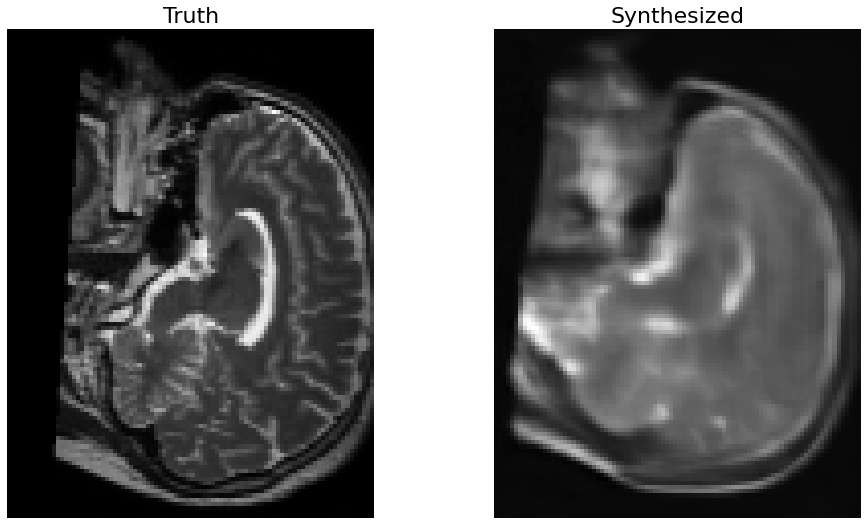

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
ax1.imshow(tgt.squeeze()[0,:,:,20], cmap='gray')
ax2.imshow(preds.squeeze()[0,:,:,20], cmap='gray'); 
ax1.set_title('Truth',fontsize=22); 
ax1.axis('off'); 
ax2.set_title('Synthesized',fontsize=22); 
ax2.axis('off'); 